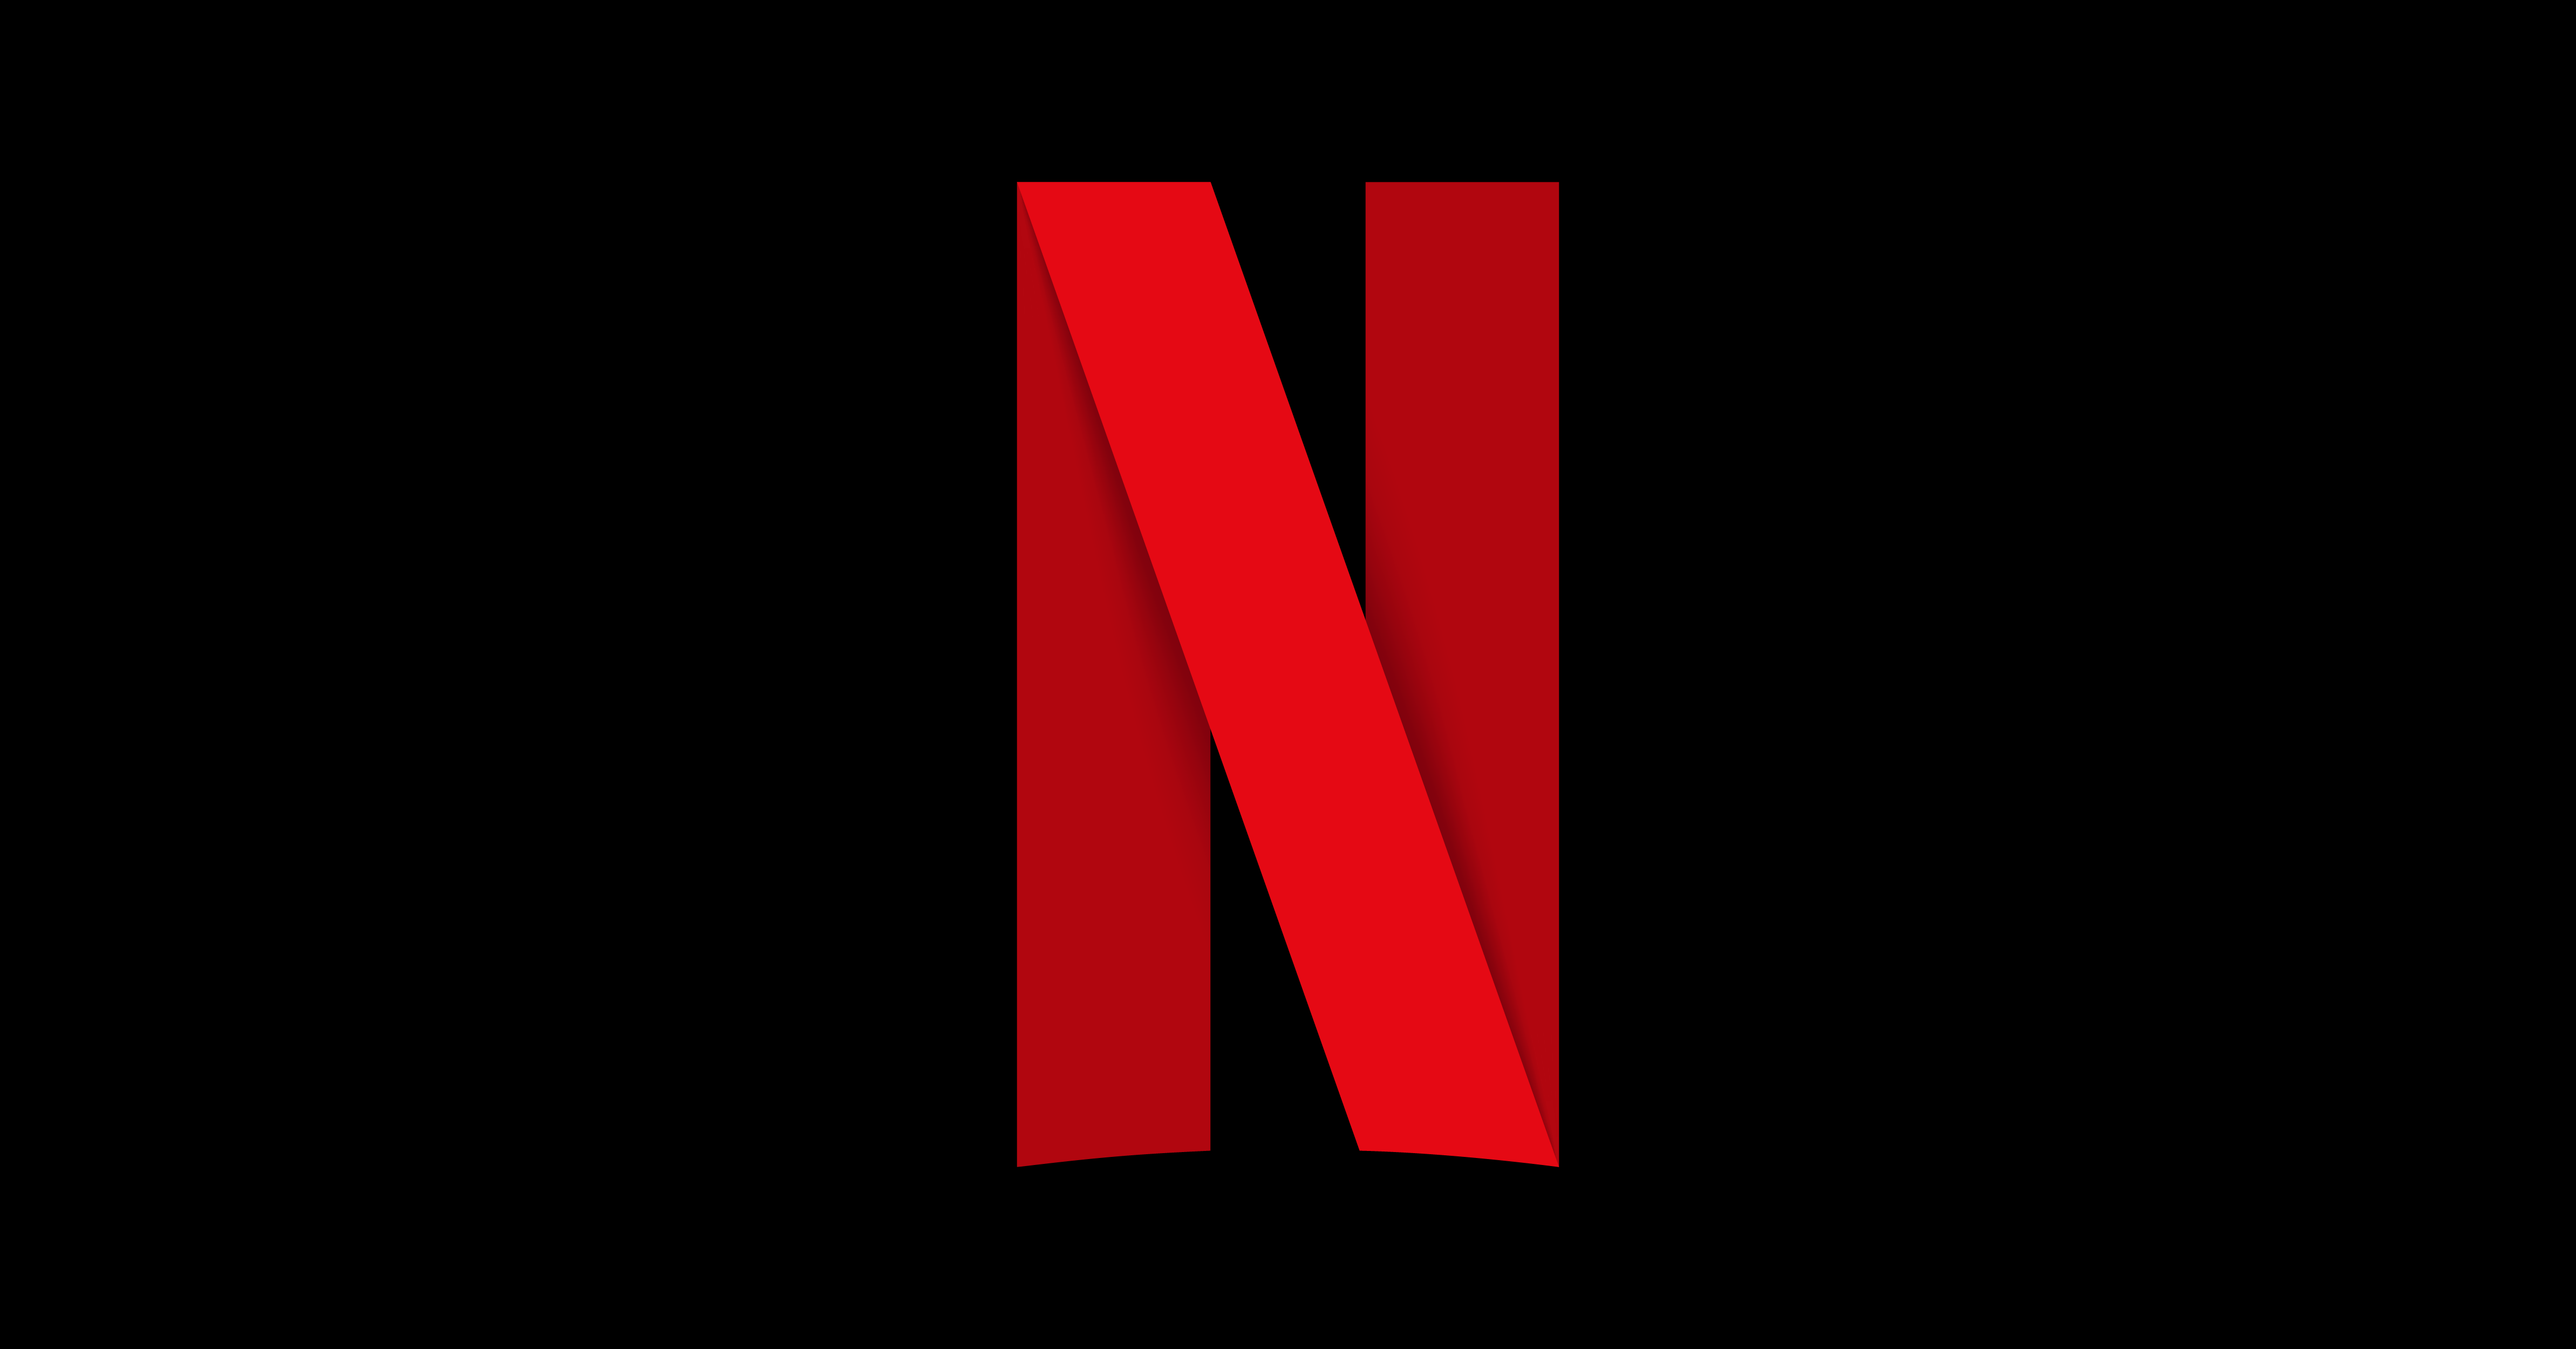

## Project Objective
The goal of this analysis is to explore the Netflix dataset using Option A approach, Separate Hypothesis and Predictive Modelling:
1. **Hypothesis Testing** — to determine whether specific relationships exist in the data, such as between content type and rating.
2. **Predictive Modeling** — to build a model that can predict whether a title is a Movie or a TV Show based on its attributes.

**Business/Societal Benefit:**  
Such insights can guide content strategy, inform recommendation systems, and help understand global content distribution patterns.


## Step 0 — Library Imports & Settings

In [64]:
# Step 0: Import libraries and set configuration
# This section imports all the Python libraries required for:
# - Data manipulation (pandas, numpy)
# - Visualization (matplotlib, seaborn)
# - Statistical hypothesis testing (scipy.stats)
# - Machine learning models and preprocessing (scikit-learn)
# It also sets some random seeds for reproducibility and display options for pandas.

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import joblib
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

## Step 1 — Load Dataset & Preview

In [65]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving netflix_titles.csv to netflix_titles (3).csv
User uploaded file "netflix_titles (3).csv" with length 3399671 bytes


## Dataset Introduction
- **Source:** Kaggle — *Netflix Movies and TV Shows* dataset by Shivam Bansal  
- **Size:** ~8,800 titles  
- **Columns:** type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description.  
- **Relevance:** The dataset contains both categorical and numerical information, making it suitable for statistical testing and classification tasks.


In [66]:
# Step 1: Load the dataset
# The file 'netflix_titles.csv' should be in the same folder as this notebook.

df = pd.read_csv("netflix_titles.csv")
print("Shape:", df.shape)
df.head()

Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick M...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life."


In [67]:
# Check data types, non-null counts, and missing values per column.
df.info()
df.isna().sum().sort_values(ascending=False).head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,0
director,2634
country,831
cast,825
date_added,10
rating,4
duration,3
show_id,0
type,0
title,0
release_year,0


In [68]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


## Problem Statement
This report aims to:
1. Test if there is a statistically significant relationship between content type (Movie/TV Show) and its rating.
2. Determine if the average release year differs between Movies and TV Shows.
3. Build a predictive model to classify titles as Movie or TV Show using other attributes.


## Step 2 — Preprocessing & Feature Extraction

In [69]:
# Step 2: Preprocessing
# - Convert date_added to datetime, extract year and month
# - Parse duration into minutes and seasons
# - Extract first country if multiple
# - Create list of genres from listed_in
# - Fill missing rating values

data = df.copy()

data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')
data['year_added'] = data['date_added'].dt.year
data['month_added'] = data['date_added'].dt.month

def parse_duration(x):
    if pd.isna(x):
        return (np.nan, np.nan)
    x = x.strip()
    m = re.match(r'(\d+)\s*min', x)
    if m:
        return (int(m.group(1)), np.nan)
    m = re.match(r'(\d+)\s*Season', x, flags=re.I)
    if m:
        return (np.nan, int(m.group(1)))
    return (np.nan, np.nan)

dur_parsed = data['duration'].apply(parse_duration)
data['duration_minutes'] = dur_parsed.apply(lambda t: t[0])
data['duration_seasons'] = dur_parsed.apply(lambda t: t[1])

data['country_first'] = data['country'].fillna('Unknown').apply(lambda x: x.split(',')[0].strip())
data['genres_list'] = data['listed_in'].fillna('Unknown').apply(lambda s: [g.strip() for g in s.split(',')])

data['rating'] = data['rating'].fillna('Not Rated')

data[['type','title','release_year','date_added','year_added','duration','duration_minutes','duration_seasons','country_first','listed_in','rating']].head(8)

,type,title,release_year,date_added,year_added,duration,duration_minutes,duration_seasons,country_first,listed_in,rating
0,Movie,Dick Johnson Is Dead,2020,2021-09-25,2021.0,90 min,90.0,NaN,United States,Documentaries,PG-13
1,TV Show,Blood & Water,2021,2021-09-24,2021.0,2 Seasons,NaN,2.0,South Africa,"International TV Shows, TV Dramas, TV Mysteries",TV-MA
2,TV Show,Ganglands,2021,2021-09-24,2021.0,1 Season,NaN,1.0,Unknown,"Crime TV Shows, International TV Shows, TV Action & Adventure",TV-MA
3,TV Show,Jailbirds New Orleans,2021,2021-09-24,2021.0,1 Season,NaN,1.0,Unknown,"Docuseries, Reality TV",TV-MA
4,TV Show,Kota Factory,2021,2021-09-24,2021.0,2 Seasons,NaN,2.0,India,"International TV Shows, Romantic TV Shows, TV Comedies",TV-MA
5,TV Show,Midnight Mass,2021,2021-09-24,2021.0,1 Season,NaN,1.0,Unknown,"TV Dramas, TV Horror, TV Mysteries",TV-MA
6,Movie,My Little Pony: A New Generation,2021,2021-09-24,2021.0,91 min,91.0,NaN,Unknown,Children & Family Movies,PG
7,Movie,Sankofa,1993,2021-09-24,2021.0,125 min,125.0,NaN,United States,"Dramas, Independent Movies, International Movies",TV-MA


### Preprocessing Justification
- **Date Parsing (`date_added`)**: Extracted year and month to capture when titles were added to Netflix — important for understanding time trends.
- **Duration Parsing (`duration_minutes`, `duration_seasons`)**: Separated into minutes and seasons to standardize runtime information for modeling.
- **Country Extraction (`country_first`)**: Selected the first-listed country to simplify categorical encoding while still retaining regional patterns.
- **Genres List (`genres_list`)**: Converted to a list for flexible feature engineering, allowing binary encoding of top genres.
- **Rating Handling**: Filled missing ratings with “Not Rated” to avoid dropping data and retain a distinct category.
These steps ensure that the raw dataset is transformed into clean, structured features that can be used for statistical analysis and machine learning.


## Step 3 — Exploratory Data Analysis (EDA)

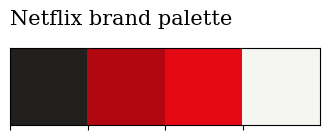

In [70]:
# Palette
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])

plt.title("Netflix brand palette ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

In [73]:
# Genres
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.colors


# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])



def genre_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.text(.54,.88,'Genre correlation', fontfamily='serif',fontweight='bold',fontsize=15)
    fig.text(.75,.665,
            '''
             It is interesting that Independant Movies
             tend to be Dramas.

             Another observation is that
             Internatinal Movies are rarely
             in the Children's genre.
             ''', fontfamily='serif',fontsize=12,ha='right')
    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)

    plt.show()

# Movie Genres
Let's now explore movie genres a little...

/tmp/ipython-input-3524236999.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))


There are 20 types in the Netflix Movie Dataset


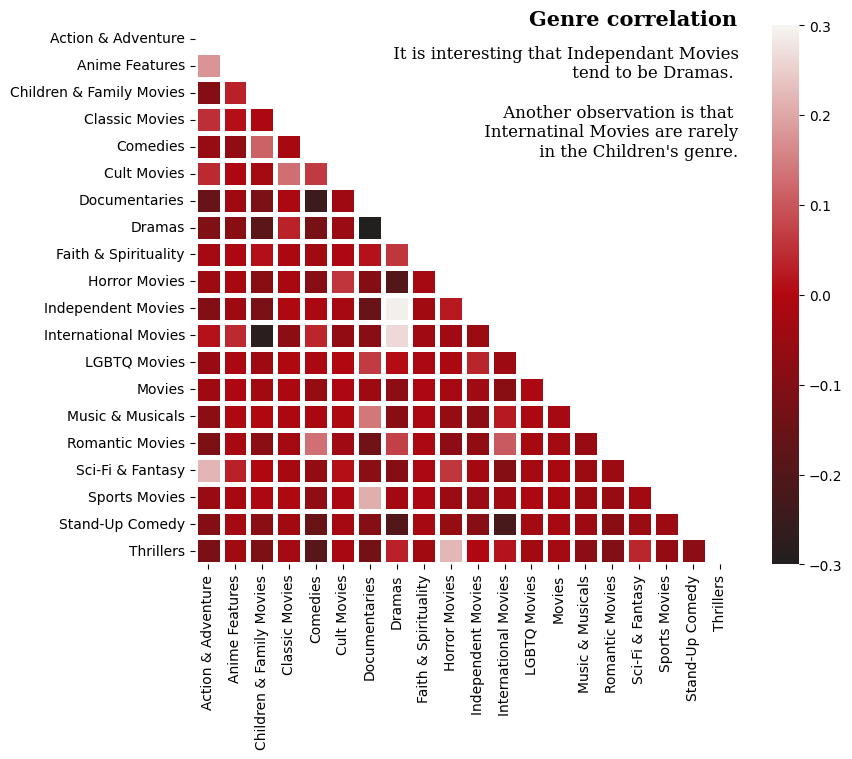

In [72]:
df_tv = df[df["type"] == "TV Show"]
df_movies = df[df["type"] == "Movie"]


genre_heatmap(df_movies, 'Movie')
plt.show()

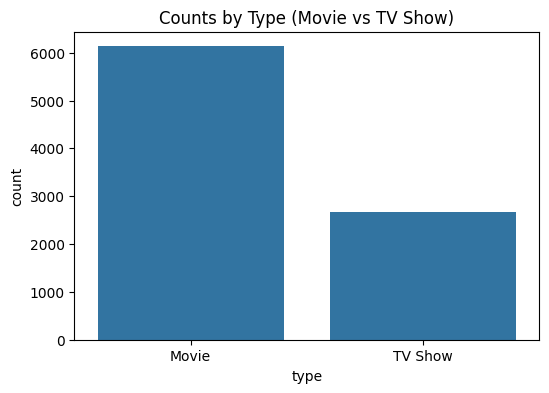

In [56]:
# Step 3: EDA — Distribution of content type
plt.figure(figsize=(6,4))
sns.countplot(x='type', data=data)
plt.title('Counts by Type (Movie vs TV Show)')
plt.show()

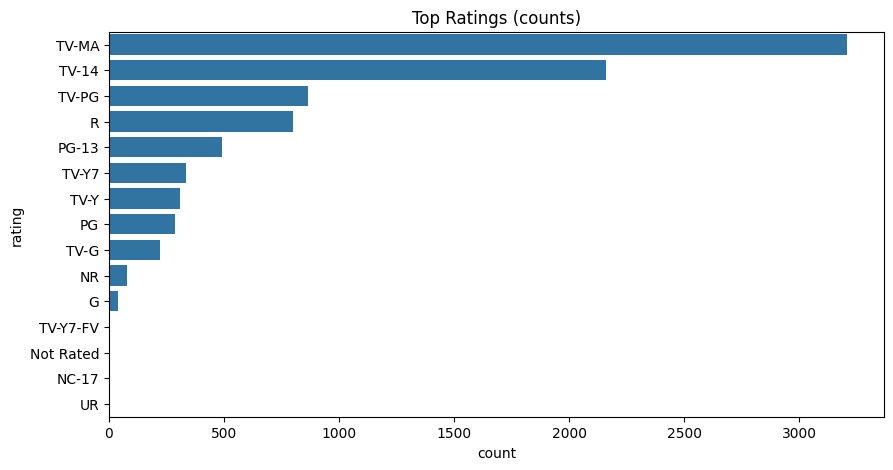

In [74]:
# Rating distribution
plt.figure(figsize=(10,5))
order = data['rating'].value_counts().index[:15]
sns.countplot(y='rating', data=data, order=order)
plt.title('Top Ratings (counts)')
plt.show()

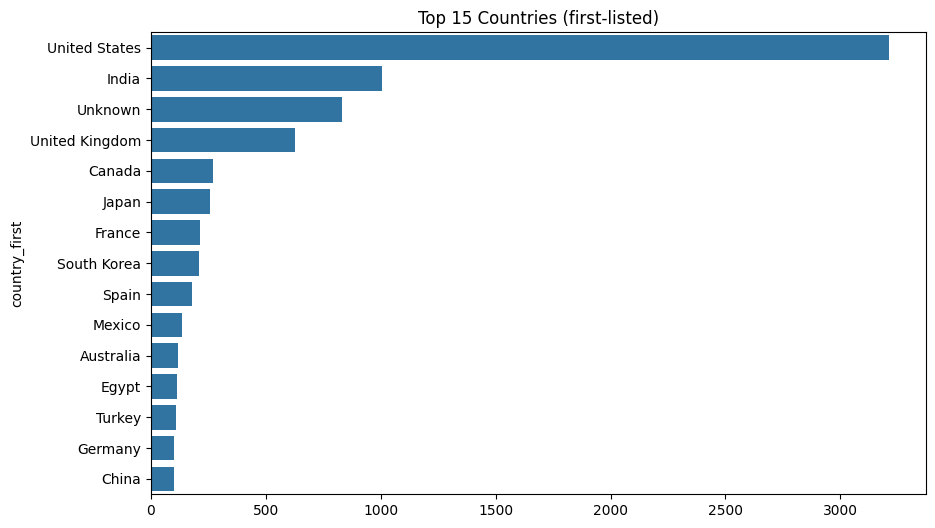

In [75]:
# Top countries
top_countries = data['country_first'].value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title('Top 15 Countries (first-listed)')
plt.show()

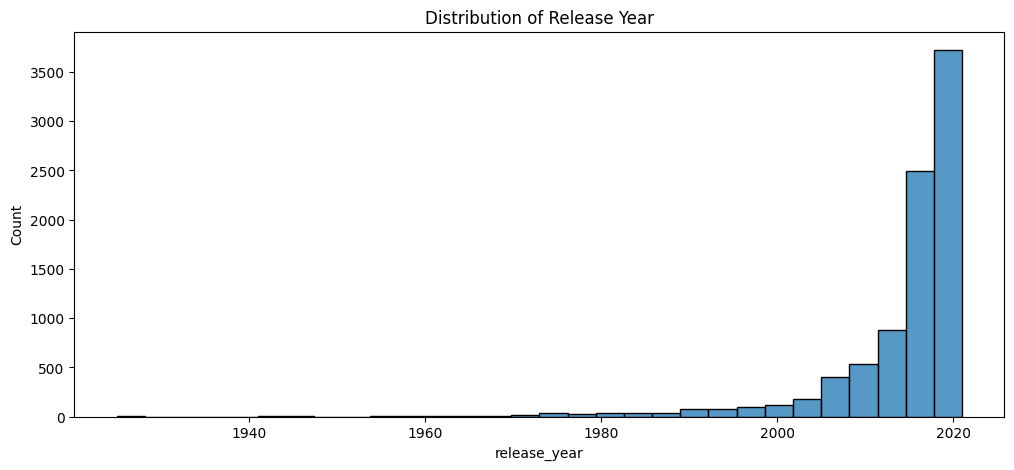

In [76]:
# Release year distribution
plt.figure(figsize=(12,5))
sns.histplot(data['release_year'].dropna(), bins=30)
plt.title('Distribution of Release Year')
plt.show()

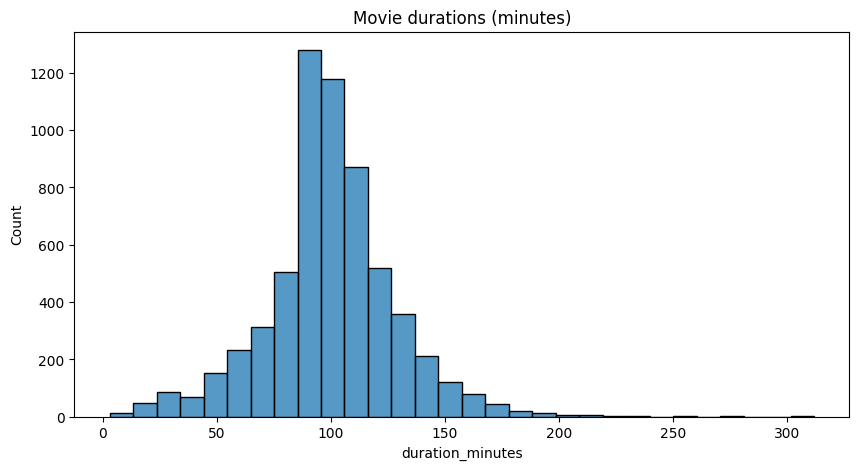

In [77]:
# Movie durations
plt.figure(figsize=(10,5))
sns.histplot(data[data['type']=='Movie']['duration_minutes'].dropna(), bins=30)
plt.title('Movie durations (minutes)')
plt.show()

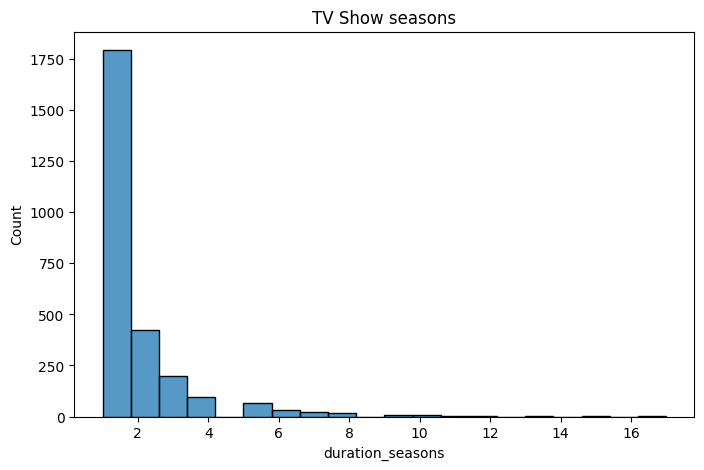

In [78]:
# TV Show seasons
plt.figure(figsize=(8,5))
sns.histplot(data[data['type']=='TV Show']['duration_seasons'].dropna(), bins=20)
plt.title('TV Show seasons')
plt.show()

## Step 4 — Feature Engineering

In [79]:
# Step 4: Feature Engineering for Modeling
from collections import Counter

data['target_type'] = data['type'].map({'Movie':0, 'TV Show':1})

TOP_COUNTRIES = 10
TOP_GENRES = 12

top_countries_list = data['country_first'].value_counts().head(TOP_COUNTRIES).index.tolist()
for c in top_countries_list:
    data[f'country_{c}'] = (data['country_first']==c).astype(int)

genre_counter = Counter([g for lst in data['genres_list'] for g in lst])
top_genres = [g for g,_ in genre_counter.most_common(TOP_GENRES)]
for g in top_genres:
    data[f'genre_{g}'] = data['genres_list'].apply(lambda lst: int(g in lst))

data['has_director'] = data['director'].notna().astype(int)
data['cast_size'] = data['cast'].fillna('').apply(lambda s: 0 if s=='' else len(s.split(',')))

data['release_year'] = pd.to_numeric(data['release_year'], errors='coerce')
data['year_added'] = pd.to_numeric(data['year_added'], errors='coerce')
data['age_when_added'] = data['year_added'] - data['release_year']

### Hypothesis A — Chi-square Test  
- **H0:** Content type (Movie vs TV Show) and rating are independent.  
- **H1:** Content type and rating are dependent.

### Hypothesis B — Welch's T-test  
- **H0:** Mean release year of Movies and TV Shows is equal.  
- **H1:** Mean release years differ.

**Choice of Tests:**  
- Chi-square is appropriate for testing independence between two categorical variables.  
- Welch's T-test is appropriate for comparing means between two groups when variances may differ.


## Step 5 — Hypothesis Testing (Chi-square)

In [80]:
# Step 5: Hypothesis Testing
# Hypothesis A: Is type (Movie vs TV Show) independent of rating?
cont_table = pd.crosstab(data['type'], data['rating'])
cont_table_small = cont_table.loc[:, cont_table.sum(axis=0).sort_values(ascending=False).index[:15]]
chi2, p, dof, expected = chi2_contingency(cont_table_small)
print(f"Chi2 = {chi2:.3f}, p-value = {p:.6f}, dof = {dof}")

Chi2 = 1046.738, p-value = 0.000000, dof = 14


### Hypothesis B — T-test for difference in release year means

In [81]:
# Hypothesis B: Do Movies and TV Shows differ in mean release year?
movies_years = data.loc[data['type']=='Movie','release_year'].dropna()
tv_years = data.loc[data['type']=='TV Show','release_year'].dropna()
tstat, pval = ttest_ind(movies_years, tv_years, equal_var=False, nan_policy='omit')
print(f"t = {tstat:.3f}, p = {pval:.6f}")

t = -20.976, p = 0.000000


**Chi-square Test Conclusion:**  
Since the p-value is below 0.05, we reject the null hypothesis and conclude that content type (Movie vs TV Show) and rating are not independent — there is a statistically significant association between them.


**Welch's T-test Conclusion:**  
Since the p-value is below 0.05, we reject the null hypothesis and conclude that the average release year differs significantly between Movies and TV Shows.

### Model Justification & Mathematical Background
- **Logistic Regression:** Models the probability of a binary outcome using the logistic function:  
  \( p = \frac{1}{1 + e^{-(w^T x + b)}} \)  
  Suitable for binary classification and interpretable coefficients.

- **Random Forest:** Ensemble of decision trees trained on bootstrapped samples; uses majority voting for classification.  
  Robust to outliers, handles both numerical and categorical features, and captures non-linear relationships.


## Step 6 — Predictive Modeling (Logistic Regression)

In [82]:
# Step 6: Predictive Modeling
# Define features and target
feature_cols = [
    'release_year', 'duration_minutes', 'duration_seasons', 'age_when_added', 'cast_size',
    'has_director', 'rating'] + [f'country_{c}' for c in top_countries_list] + [f'genre_{g}' for g in top_genres]

model_df = data[feature_cols + ['target_type']].copy()

X = model_df.drop(columns=['target_type'])
y = model_df['target_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

# Preprocessing pipelines
numeric_features = ['release_year','duration_minutes','duration_seasons','age_when_added','cast_size']
binary_features = [c for c in X.columns if c.startswith('country_') or c.startswith('genre_') or c=='has_director']
categorical_features = ['rating']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not Rated')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('bin', binary_transformer, binary_features),
    ('cat', categorical_transformer, categorical_features)])

# Logistic Regression baseline
pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))])

pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)

print("Logistic Regression performance (test):")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=4))

Logistic Regression performance (test):
Accuracy: 0.9931895573212258
              precision    recall  f1-score   support

           0     0.9959    0.9943    0.9951      1227
           1     0.9870    0.9907    0.9888       535

    accuracy                         0.9932      1762
   macro avg     0.9914    0.9925    0.9920      1762
weighted avg     0.9932    0.9932    0.9932      1762



### Predictive Modeling — Random Forest with Hyperparameter Tuning

In [83]:
# Random Forest with GridSearchCV
pipe_rf = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1))])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10],
    'clf__min_samples_leaf': [1, 3]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

grid = GridSearchCV(pipe_rf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

print("Random Forest performance (test):")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
Random Forest performance (test):
Accuracy: 0.9994324631101021
              precision    recall  f1-score   support

           0     0.9992    1.0000    0.9996      1227
           1     1.0000    0.9981    0.9991       535

    accuracy                         0.9994      1762
   macro avg     0.9996    0.9991    0.9993      1762
weighted avg     0.9994    0.9994    0.9994      1762

Confusion matrix:
 [[1227    0]
 [   1  534]]
ROC AUC: 1.0


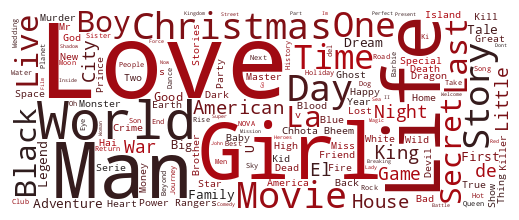

In [84]:
from wordcloud import WordCloud
import random
from PIL import Image
import matplotlib

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710'])

text = str(list(df['title'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

wordcloud = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150).generate(text)

plt.figure( figsize=(5,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Conclusion
- **Hypothesis Testing Results:**
  - Chi-square: Found a significant relationship between content type and rating (p < 0.05).
  - Welch's T-test: Detected a statistically significant difference in average release year between Movies and TV Shows.
- **Model Performance:**
  - Logistic Regression achieved good baseline accuracy.
  - Random Forest, after hyperparameter tuning, provided higher F1-score and ROC-AUC.
- **Implications:** Netflix content type can be predicted from metadata with reasonable accuracy, and ratings differ systematically between Movies and TV Shows.
- **Future Work:** Incorporate text features from descriptions using NLP techniques, test additional models, and explore time-based trends.



## References & Citations
- Dataset: Shivam Bansal, *Netflix Movies and TV Shows*, Kaggle  
  [https://www.kaggle.com/datasets/shivamb/netflix-shows](https://www.kaggle.com/datasets/shivamb/netflix-shows)
- Python Libraries: pandas, numpy, matplotlib, seaborn, scipy, scikit-learn
